In [1]:
#dependancies, run this cell to make sure everything will work
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import utils
from keras import backend as K
from keras import layers
from keras import objectives
from keras import optimizers

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from IPython.display import clear_output

from sklearn.metrics import classification_report
from skimage import data, img_as_float
from skimage.util import random_noise


Using TensorFlow backend.


# Create the datasets for the MLP and VAE models.
### The VAEs will be used to create further MLP datsets as well.

In [2]:
################# methods for shaping our data ##############
def reshape_x(X, input_shape):
    X = np.reshape(X, [-1, input_shape])
    X = X.astype('float32') / 255
    return X
def reshape_y(y, num_categories):
    y = utils.to_categorical(y, num_categories)
    return y
###########################################################

############# Retrieve training data ######################
#get the mnist data using keras utility
(x_train, y_train),(x_test,y_test) = mnist.load_data()

#use numpy functions to sort the data by label
index = np.argsort(y_train)
x_train = x_train[index]
y_train = y_train[index]
""" #################### Data sets of For VAEs ############# """
#retrieve the zeros and store them aside.
zeros = x_train[y_train == 0]
zeros_first500 = zeros[:500]
zeros_first50 = zeros[:50]
zeros_random50 = zeros[::118] #gives 51
zeros_random50 = zeros_random50[:50] #cut off the last.

#sets of zeros comprised of noisy replicates for experimentation.
zeros_repeated = np.repeat(zeros_first50, 100, axis=0)
zeros_gaussian_noise = zeros_repeated
zeros_various_noise = np.repeat(zeros_repeated, 12, axis = 0)
#Get noisy replicated of the randomm 50
zeros_repeated = np.repeat(zeros_random50, 100, axis=0)
zeros_gaussian_rand = zeros_repeated 
#create noise
#Gaussian noise sets:
zeros_gaussian_noise[:] = [random_noise(x) for x in zeros_gaussian_noise]
zeros_gaussian_rand[:] = [random_noise(x) for x in zeros_gaussian_rand]
#large set with multiple noise types.
zeros_various_noise[:10000] = [random_noise(x) for x in zeros_various_noise[:10000]]
zeros_various_noise[10000:20000] = [random_noise(x, mode='poisson') for x in zeros_various_noise[10000:20000]]
zeros_various_noise[20000:30000] = [random_noise(x, mode='salt')  for x in zeros_various_noise[20000:30000]]
zeros_various_noise[30000:40000] = [random_noise(x, mode='pepper') for x in zeros_various_noise[30000:40000]]
zeros_various_noise[40000:50000]= [random_noise(x, mode='s&p')  for x in zeros_various_noise[40000:50000]]
zeros_various_noise[50000:] = [random_noise(x,mode='speckle')  for x in zeros_various_noise[50000:]]

#Validation data for VAE training: all the zeros from the mnist test set.
vae_test = x_test[y_test==0]
""" #######################################################"""

""" ##################### Data sets for MLPs ####################"""
#Create a full dataset with only 500 zeros
x_train_uneven = x_train[5423:]
y_train_uneven = y_train[5423:]

#Create a full dataset with only the first 50 zeros
x_train_scant = x_train[5873:]
y_train_scant = y_train[5873:]

#Create a full dataset with the 50 randomly selected zeros
x_train_random_scant = zeros_random50
x_train_random_scant = np.concatenate((x_train_random_scant, x_train_scant[50:]))

#Create a set where the zeros are Guassian noise replicates of first 50 zeros, plus the 50 gt
x_train_noise = zeros_gaussian_noise
x_train_noise = np.concatenate((x_train_noise, x_train[5873:]))

#Create a set where the zeros are Gaussian noise replicates of 50 random zeros
x_train_rand_noise = zeros_gaussian_rand
x_train_rand_noise = np.concatenate((x_train_rand_noise, x_train[5873:]))

#create a smaller y_train set to match the synthetic sets
y_train_syn = y_train[873:] 
"""#################################################################################"""


"""#################### Reshape all the data ########################################"""
#Get the input shape for MLPs: 1 node per pixel
image_size = x_train.shape[1]
input_shape = image_size * image_size

#Use our methods to reshape the data as needed for MLP training.
x_train = reshape_x(x_train, input_shape)
x_test = reshape_x(x_test, input_shape)
zeros_first500 = reshape_x(zeros_first500, input_shape)
zeros_first50 = reshape_x(zeros_first50, input_shape)
zeros_random50 = reshape_x(zeros_random50, input_shape)
zeros_gaussian_noise = reshape_x(zeros_gaussian_noise, input_shape)
zeros_various_noise = reshape_x(zeros_various_noise, input_shape)
zeros_gaussian_rand = reshape_x(zeros_gaussian_rand, input_shape)
x_train_uneven = reshape_x(x_train_uneven, input_shape)
x_train_scant = reshape_x(x_train_scant, input_shape)
x_train_noise = reshape_x(x_train_noise, input_shape) 
x_train_rand_noise = reshape_x(x_train_rand_noise, input_shape)
x_train_random_scant = reshape_x(x_train_random_scant, input_shape)
vae_test = reshape_x(vae_test, input_shape)


y_train = reshape_y(y_train, 10)
y_train_uneven = reshape_y(y_train_uneven, 10)
y_train_scant = reshape_y(y_train_scant, 10)
y_train_syn = reshape_y(y_train_syn, 10)
y_test = reshape_y(y_test, 10)
"""################################################################################"""
print("Formatted training sets for MLPs and VAEs.")

Formatted training sets for MLPs and VAEs.


# Create the VAE models
### Create VAEs using the different zeros data sets. Use them to create MLP training data

In [4]:
#########################VAE Model##############################
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#VAE loss is sum of reconstruction loss and KL divergence

#The optimizer used in VAE functions below.
op = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)

#Used to create new models
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)


def create_vae(input_size, batch_size=100):
    intermediate_dim=512
    latent_dim = 2
    vae_inputs = Input(batch_shape=(batch_size,784)) #shape is batchsize * image size
    X = Dense(intermediate_dim, activation='relu')(vae_inputs)
    z_mean = Dense(latent_dim, name='z_mean')(X)
    z_log_var = Dense(latent_dim, name='z_log_var')(X)
    #Use the parameter trick
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    #Decoder
    decoder_X = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(784, activation='sigmoid')
    X_decoded = decoder_X(z)
    X_decoded_mean = decoder_mean(X_decoded)

    #Create the end-to-end VAE
    vae = Model(vae_inputs, X_decoded_mean)
    #create encoder
    encoder = Model(vae_inputs, z_mean)
    #create generator
    decoder_input = Input(shape=(latent_dim,))
    _X_decoded = decoder_X(decoder_input)
    _X_decoded_mean = decoder_mean(_X_decoded)
    generator = Model(decoder_input, _X_decoded_mean)
    
    def vae_loss(x, x_decoded_mean):
        xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
                            axis=-1)
        return xent_loss + kl_loss
    return {'vae':vae, 'encoder':encoder, 'generator':generator, 'loss': vae_loss}
                
#Visualize the results from a vae
def plot_manifold(generator, std, filename):
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-std, std, n)
    grid_y = np.linspace(-std, std, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                    j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename, bbox_inches='tight')
    plt.show()


#in run_vae, vae_models param should be a dict containing the vae, encoder, and generator
def run_vae(vae_models, X, y, manifold_file, sample_file, batch_size=100, epochs=100, manifold_std=5, 
               num_zeros=5873):
    
    for model in ('vae', 'encoder', 'generator'):
        reset_weights(vae_models[model])
    
    vae_models['vae'].compile(optimizer=op, loss=vae_models['loss'])
    vae_models['vae'].fit(X,X, shuffle=True, epochs=epochs, 
            batch_size=batch_size, validation_data=(y,y))
    clear_output()
    plot_manifold(vae_models['generator'],manifold_std, manifold_file)
    
    synthetic_zeros = np.empty([num_zeros, 784])
    dev=[-manifold_std, manifold_std]
    for i in range (num_zeros):
        xi = np.random.random_sample() * np.random.choice(dev)
        yi = np.random.random_sample() * np.random.choice(dev)
        z_sample = np.array([[xi,yi]])
        x_decoded = vae_models['generator'].predict(z_sample)
        synthetic_zeros[i] = x_decoded
    test_image = synthetic_zeros[1].reshape(28, 28)
    plt.imshow(test_image)
    plt.savefig(sample_file, bbox_inches='tight')
    return synthetic_zeros


### Use the VAE methods to prepare data for additional MLPs
#### We will compare MLPs trained directly vs those trained by VAE generated synthetic data

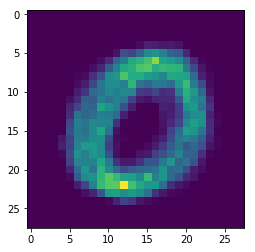

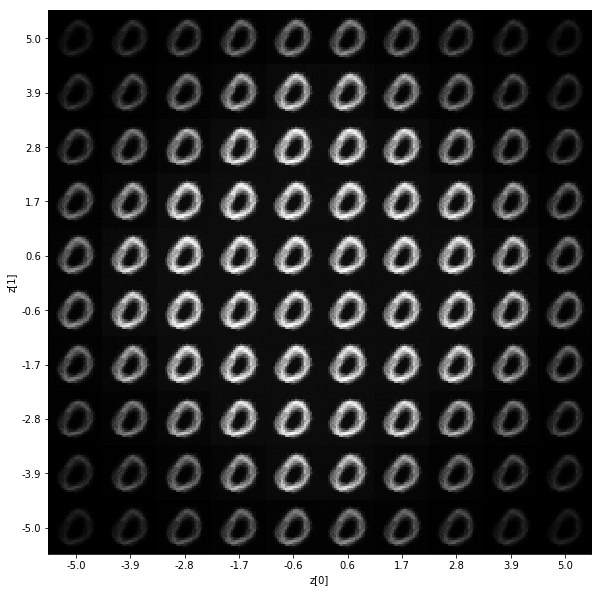

Complete.


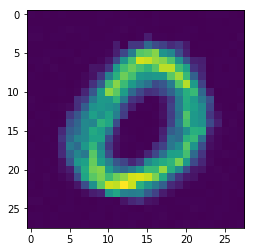

In [5]:
"""##################################### Create the VAEs ###############################################"""
#using ground truth composed of first 50 zeros in x_train
vae_ground_truth = create_vae(input_size=50, batch_size=50) #ground truth is tiny so we need smaller input/batch
vae_gaussian = create_vae(100)
#using ground truth of random 50 zeros from x train
vae_r_ground_truth = create_vae(50,50)
vae_r_gaussian = create_vae(100)
#using large set of multi noised zeros
vae_multi_noise = create_vae(100)
"""#####################################################################################################"""

"""############################## Create synthetic zero datasets#########################################"""

zeros_gt = run_vae(vae_models=vae_ground_truth, X=zeros_first50, y=vae_test[:900], 
                   manifold_file='ground_truth_vae_manifold.png',
                  sample_file='ground_truth_vae_sample.png', batch_size=50)
zeros_gauss = run_vae(vae_gaussian, zeros_gaussian_noise, vae_test[:900], 'guassian_vae_manifold.png',
                  'gaussian_vae_sample.png', batch_size=100)
zeros_r_gt = run_vae(vae_r_ground_truth, zeros_random50, vae_test[:900], 'ground_truth_r_vae_manifold.png',
                  'ground_truth_r_vae_sample.png', batch_size=50)
zeros_r_gauss = run_vae(vae_r_gaussian, zeros_gaussian_rand, vae_test[:900], 'guassian_r_vae_manifold.png',
                  'gaussian_r_vae_sample.png', batch_size=100)
zeros_multi = run_vae(vae_multi_noise, zeros_various_noise, vae_test[:900], 'multinoise_vae_manifold.png',
                  'gaussian_r_vae_sample.png', batch_size=100, epochs = 20)
"""#####################################################################################################"""

print("Complete.")



In [6]:
#Use the synthetic zeros to create MLP models
def create_MLP():
    inputs = layers.Input(shape =(784,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(10, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def run_MLP(model, model_name, x_train, y_train, x_test, y_test, results_file, batch_size=128, epochs=20):
    reset_weights(model) #just in case
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                               verbose=1, validation_data=(x_test,y_test))
    clear_output()
    print('Training complete. Running classification test for ', model_name)
    y_prob = model.predict(x_test)
    y_pred = y_prob.argmax(axis=-1)
    y_pred = utils.to_categorical(y_pred, 10)
    with open(results_file, 'w') as f:
        out = "Model: " + model_name
        f.write(out)
        f.write(classification_report(y_test, y_pred))
    print('Report complete.')
    return history
    

In [7]:
""" RAN OUT OF MEMORY SO I NEEDED TO FREE SOME UP """
zeros_various_noise = []

In [8]:
#These datasets will form our experimental MLP data.
x_gt_vae = np.concatenate((zeros_first50, zeros_gt, x_train[5923:]))

x_gauss_vae = np.concatenate((zeros_first50, zeros_gauss, x_train[5923:]))

x_r_gt_vae = np.concatenate((zeros_random50, zeros_r_gt, x_train[5923:]))

x_r_gauss_vae = np.concatenate((zeros_random50, zeros_r_gauss, x_train[5923:]))

x_multi_vae = np.concatenate((zeros_first50, zeros_multi, x_train[5923:]))

# Now, we will run the MLPs.
#### Run the following:
        Benchmarks, to show how recall and precision are affected by underepresented class:
        - MLP with full mnist data, our control
        - MLP with only 500 class 0 instance, ~6000 each of other classes
        - MLP with only first 50 class 0 instances, ~6000 each of other classes
        - MLP with random 50 class 0 instances, ~6000 each of other classes
        Controls: USe the same data which the VAEs were trained with to see if it's worth doing.
        - MLP with a set of 5923 zeros produced from Gaussian noised replicates of the first 50
        - MLP with a set of 5923 zeros produced from Gaussian noised replicates of random 50
        VAE sets: MLPs trained with the VAE synthesized zero sets.
        In the VAE sets, 50 zeros are ground truth and 5873 are synthesized.
        - zeros generated from ground truth trained VAE (50 first instances)
        - zeros generated from groung truth trained VAE (50 random instances)
        - zeros generated from Gaussian noise replicates of first 50 instances
        - zeros generated from Gaussian noise replicates of random 50 instances
        - zeros generated from a VAE trained on a magnitude larger training set comprised of 6 different noise 
          techniques performed on replicates of the first 50 instances.
          

In [9]:

control_mlp = create_MLP()
first500_mlp = create_MLP()
first50_mlp = create_MLP()
rand50_mlp = create_MLP()

gauss_mlp = create_MLP()
gauss_r_mlp = create_MLP()

vae_gt_mlp = create_MLP() 
vae_r_gt_mlp = create_MLP()
vae_gauss_mlp = create_MLP()
vae_r_gauss_mlp = create_MLP()
vae_multi_mlp = create_MLP()

#model, model_name, x_train, y_train, x_test, y_test, results_file, batch_size=128, epochs=20
control_his = run_MLP(control_mlp, 'Control', x_train, y_train, x_test, y_test, 'Control_Report.txt')
f500_his = run_MLP(first500_mlp, '10% Class Representation', x_train_uneven, y_train_uneven,
                  x_test, y_test, '500_instance_report.txt')
f50_his = run_MLP(first50_mlp, '1% Class Representation Consecutive', x_train_scant, y_train_scant,
                  x_test, y_test, '50_instance_report.txt')
r50_his = run_MLP(rand50_mlp, '1% Class Representation Random', x_train_random_scant, y_train_scant,
                  x_test, y_test, '50_instance_report_r.txt')

gauss_his = run_MLP(gauss_mlp, 'Gaussian Noised Replicates', x_train_noise, y_train_syn,
                  x_test, y_test, 'gauss_mlp_report.txt')
gauss_r_his = run_MLP(gauss_r_mlp, 'Gaussian noised random sample replicates', x_train_rand_noise, y_train_syn,
                  x_test, y_test, 'gauss_r_mlp_report.txt')

vae_gt_his = run_MLP(vae_gt_mlp, 'VAE ground truth generated', x_gt_vae, y_train,
                  x_test, y_test, 'vae_gt_report.txt')
vae_r_gt_his = run_MLP(vae_r_gt_mlp, 'VAE randomized ground truth', x_r_gt_vae, y_train,
                  x_test, y_test, 'vae_gt_r_report.txt')
vae_gauss_his = run_MLP(vae_gauss_mlp, 'VAE gauss trained sequential', x_gauss_vae, y_train,
                  x_test, y_test, 'vae_gauss_report.txt')
vae_gauss_r_his = run_MLP(vae_r_gauss_mlp, 'VAE gauss trained random', x_r_gauss_vae, y_train,
                  x_test, y_test, 'vae_gauss_r_report.txt')
vae_multi_his = run_MLP(vae_multi_mlp, 'VAE multi noise trained', x_multi_vae, y_train,
                  x_test, y_test, 'vae_multi_report.txt')

Training complete. Running classification test for  VAE multi noise trained
Report complete.


 ## Plot the results:
 ### Plot Control MLPs accuracy and loss.
 ### Plot bar charts comparing precision and/or recall of results

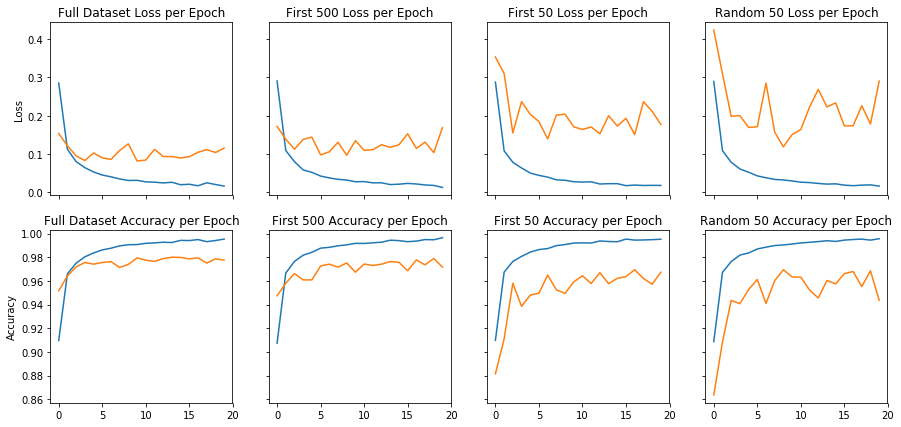

In [10]:
#Plot the history of the Synthetically Trained model vs the real model and skewed model
#Again show loss function and accuracy 
f, axarr = plt.subplots(2, 4, sharex='col', sharey='row')
axarr[0, 0].plot(control_his.history['loss'])
axarr[0, 0].plot(control_his.history['val_loss'])
axarr[0, 0].set_title('Full Dataset Loss per Epoch')
axarr[0, 0].set_ylabel('Loss')
axarr[0, 1].plot(f500_his.history['loss'])
axarr[0, 1].plot(f500_his.history['val_loss'])
axarr[0, 1].set_title('First 500 Loss per Epoch')
axarr[0, 2].plot(f50_his.history['loss'])
axarr[0, 2].plot(f50_his.history['val_loss'])
axarr[0, 2].set_title('First 50 Loss per Epoch')
axarr[0, 3].plot(r50_his.history['loss'])
axarr[0, 3].plot(r50_his.history['val_loss'])
axarr[0, 3].set_title('Random 50 Loss per Epoch')



axarr[1, 0].plot(control_his.history['acc'])
axarr[1, 0].plot(control_his.history['val_acc'])
axarr[1, 0].set_title('Full Dataset Accuracy per Epoch')
axarr[1, 0].set_ylabel('Accuracy')
axarr[1, 1].plot(f500_his.history['acc'])
axarr[1, 1].plot(f500_his.history['val_acc'])
axarr[1, 1].set_title('First 500 Accuracy per Epoch')
axarr[1, 2].plot(f50_his.history['acc'])
axarr[1, 2].plot(f50_his.history['val_acc'])
axarr[1, 2].set_title('First 50 Accuracy per Epoch')
axarr[1, 3].plot(r50_his.history['acc'])
axarr[1, 3].plot(r50_his.history['val_acc'])
axarr[1, 3].set_title('Random 50 Accuracy per Epoch')
f.set_size_inches(15,7)
plt.savefig('plot_controls.png', bbox_inches='tight')
plt.show()

In [16]:
""" RESULTS!          Precision   Recall      F1     for class 0: (copy-pasted from the saved report files)
#############CONTROLS############################
Control dataset:         0.98      0.99      0.99 
500 instances to MLP:    1.00      0.90      0.95
#################################################

###########Ground Truth Trained Models###########
50 instance S to MLP:    1.00      0.85      0.92
50 isnatces R to MLP:    1.00      0.62      0.77

GT S VAE set to MLP:     0.99      0.80      0.88  
GT R VAE set to MLP:     1.00      0.33      0.49
#################################################

###### Gaussian Replicate Trained Models ########
gaussian S to MLP:       1.00      0.75      0.85
gaussian R to MLP:       1.00      0.30      0.46

Gauss. S VAE set :       1.00      0.78      0.88
Gauss R VAE set  :       1.00      0.84      0.91

MultiNoise VAE set:      1.00      0.76      0.86
#################################################

Figures to show: 
-Control, 500, and two 50s together
-Two 50s and two 50s from VAE together

-S 50, gauss-mlp, gauss-vae-mlp, multi-noise
-R 50, gauss-mlp, gauss-vae-mlp
"""
gt_vae_res = [.99, 0.80, 0.88 ]
gt_r_vae_res = [1.00, 0.33, 0.49]
gauss_dir_res = [1.00, 0.75, 0.85]
gauss_r_dir_res=[1.00, 0.3, 0.46]
gauss_vae_res = [1.00,0.78,0.88]
gauss_r_vae_res=[1.00,0.84,0.91]
multi_res=[1.00,0.76,0.86]

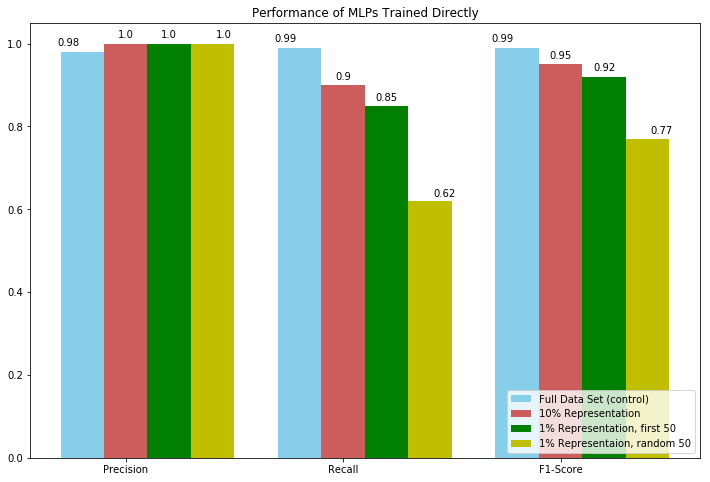

In [15]:
control_res = [.98, .99, .99]
f500_res = [1.00, .90, .95]
f50_res = [1.00, 0.85, 0.92]
r50_res = [1.00, 0.62, 0.77]

values =['Precision', 'Recall', 'F1-Score']

width = 0.2  # the width of the bars
ind = np.arange(len(control_res))
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, control_res, width,
                color='SkyBlue', label='Full Data Set (control)')
rects2 = ax.bar(ind, f500_res, width,
                color='IndianRed', label='10% Representation')
rects3 = ax.bar(ind + width, f50_res, width,
                color='g', label='1% Representation, first 50')
rects4 = ax.bar(ind + 2* width, r50_res, width, color = 'y', label='1% Representaion, random 50')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Performance of MLPs Trained Directly')
ax.set_xticks(ind)
ax.set_xticklabels(values)
ax.legend(loc="lower right")

def autolabel(rects, xpos='center'):
    xpos = xpos.lower()  
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')

autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "center")
autolabel(rects4, 'right')

fig.set_size_inches(12,8)
plt.savefig('Barchart_Control_Group.png')
plt.show()

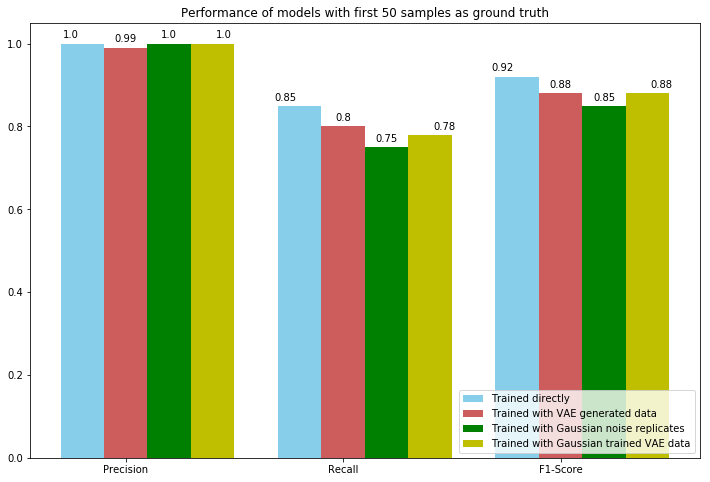

In [17]:
values =['Precision', 'Recall', 'F1-Score']

width = 0.2  # the width of the bars
ind = np.arange(len(control_res))
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, f50_res, width,
                color='SkyBlue', label='Trained directly')
rects2 = ax.bar(ind, gt_vae_res, width,
                color='IndianRed', label='Trained with VAE generated data')
rects3 = ax.bar(ind + width, gauss_dir_res, width,
                color='g', label='Trained with Gaussian noise replicates')
rects4 = ax.bar(ind + 2* width, gauss_vae_res, width, color = 'y', label='Trained with Gaussian trained VAE data')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Performance of models with first 50 samples as ground truth')
ax.set_xticks(ind)
ax.set_xticklabels(values)
ax.legend(loc="lower right")


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "center")
autolabel(rects4, 'right')

fig.set_size_inches(12,8)
plt.savefig('Barchart_first50.png')
plt.show()

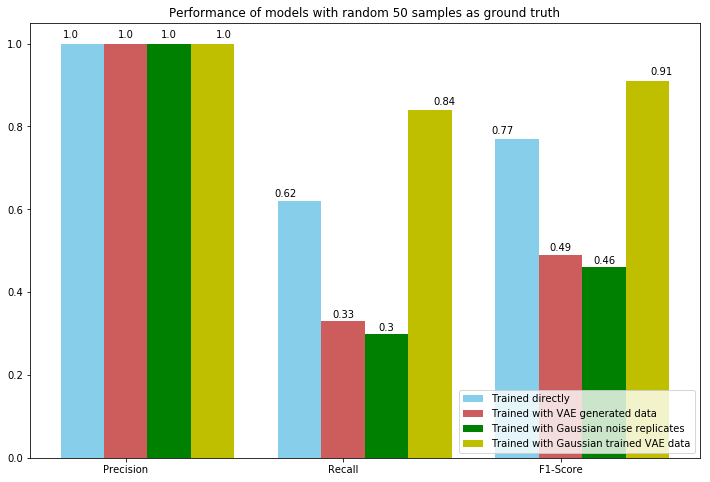

In [18]:
values =['Precision', 'Recall', 'F1-Score']

width = 0.2  # the width of the bars
ind = np.arange(len(control_res))
fig, ax = plt.subplots()
rects1 = ax.bar(ind - width, r50_res, width,
                color='SkyBlue', label='Trained directly')
rects2 = ax.bar(ind, gt_r_vae_res, width,
                color='IndianRed', label='Trained with VAE generated data')
rects3 = ax.bar(ind + width, gauss_r_dir_res, width,
                color='g', label='Trained with Gaussian noise replicates')
rects4 = ax.bar(ind + 2* width, gauss_r_vae_res, width, color = 'y', label='Trained with Gaussian trained VAE data')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Performance of models with random 50 samples as ground truth')
ax.set_xticks(ind)
ax.set_xticklabels(values)
ax.legend(loc="lower right")


autolabel(rects1, "left")
autolabel(rects2, "center")
autolabel(rects3, "center")
autolabel(rects4, 'right')

fig.set_size_inches(12,8)
plt.savefig('Barchart_random50.png')
plt.show()

# Conclusion:
## Using the VAE to create synthetic data can be either helpful or deleterious, depending on the distribution of data.

### When the training data was composed of the first 50 instances of the class zero from the full mnist data, using VAE replicates or Gaussian noise replicates resulted in decrease in recall of 5% and 10% compared to directly training the MLP with the imbalanced dataset, respectively. Using a VAE which was trained on the Gaussian noise replicate data resuted in a decrease of 7% in recall.

### However, when using a random 50 instances of the training data from class zero, using a syntehtic data set created by a Gaussian noised replicate trained VAE resulted in a 22% increase in recall and a 14% increase in F1-score. 

### Therefore, under certain conditions, it is posssible for VAE synthesized data to greatly improve a model's ability to identify mis represented class. Without prior knowledge of the distribution of the dataset, it would be good practice to try directly training the model with the dataset as well.